In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import itertools
from scipy.stats import gaussian_kde

from rdkit import Chem
from rdkit.Chem import Descriptors, rdFMCS

Notebook to parse loss history data in ./process/ and plot progressions.

In [2]:
pretrain = pd.read_csv("process/pretraining_history.csv")
pretrain_t_err = pretrain["mae"]
pretrain_v_err = pretrain["val_mae"]

transfer_t_err_nested_g = []
transfer_v_err_nested_g = []
transfer_t_err_nested = []
transfer_v_err_nested = []
for file in glob.glob("process/training_history_transfer_*.csv"):
    
    transfer_df = pd.read_csv(file)
    transfer_t_err_nested_g.append(np.minimum.accumulate(transfer_df["mae"]))
    transfer_v_err_nested_g.append(np.minimum.accumulate(transfer_df["val_mae"]))
    transfer_t_err_nested.append(transfer_df["mae"])
    transfer_v_err_nested.append(transfer_df["val_mae"])

finetune_t_err_nested_g = []
finetune_v_err_nested_g = []
finetune_t_err_nested = []
finetune_v_err_nested = []
for file in glob.glob("process/training_history_finetuned_*.csv"):
    
    finetune_df = pd.read_csv(file)
    finetune_t_err_nested_g.append(np.minimum.accumulate(finetune_df["mae"]))
    finetune_v_err_nested_g.append(np.minimum.accumulate(finetune_df["val_mae"]))
    finetune_t_err_nested.append(finetune_df["mae"])
    finetune_v_err_nested.append(finetune_df["val_mae"])

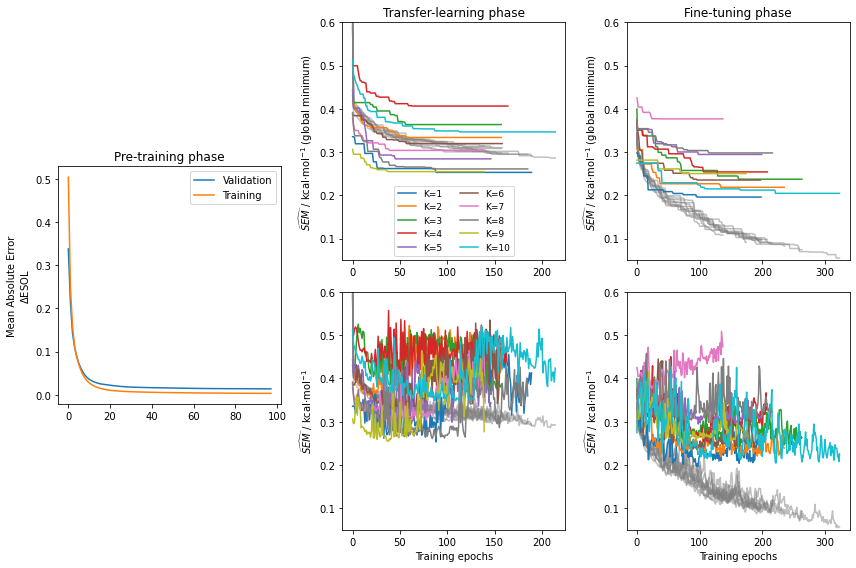

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

axes[0][0].plot(pretrain["val_mae"], label="Validation")
axes[0][0].plot(pretrain["mae"], label="Training")

# global minimum plots
for transfer_t_err in transfer_t_err_nested_g:
    axes[0][1].plot(transfer_t_err, color="grey", alpha=0.5, zorder=-10)

for i, transfer_v_err in enumerate(transfer_v_err_nested_g):
    axes[0][1].plot(transfer_v_err, label="K="+str(i+1))

for finetune_t_err in finetune_t_err_nested_g:
    axes[0][2].plot(finetune_t_err, color="grey", alpha=0.5, zorder=-10)

for i, finetune_v_err in enumerate(finetune_v_err_nested_g):
    axes[0][2].plot(finetune_v_err, label="K="+str(i+1))

# absolute values plots

for transfer_t_err in transfer_t_err_nested:
    axes[1][1].plot(transfer_t_err, color="grey", alpha=0.5, zorder=-10)

for i, transfer_v_err in enumerate(transfer_v_err_nested):
    axes[1][1].plot(transfer_v_err, label="K="+str(i+1))

for finetune_t_err in finetune_t_err_nested:
    axes[1][2].plot(finetune_t_err, color="grey", alpha=0.5, zorder=-10)

for i, finetune_v_err in enumerate(finetune_v_err_nested):
    axes[1][2].plot(finetune_v_err, label="K="+str(i+1))
    
    
# formatting
axes[0][0].legend()
axes[0][1].legend(loc='lower center', ncol=2, prop={'size': 9})
axes[0][0].set_ylabel("Mean Absolute Error\n$\Delta$ESOL")

axes[0][1].set_ylabel("$\widehat{SEM}$ / kcal$\cdot$mol$^{-1}$ (global minimum)")
axes[0][2].set_ylabel("$\widehat{SEM}$ / kcal$\cdot$mol$^{-1}$ (global minimum)")

axes[1][1].set_ylabel("$\widehat{SEM}$ / kcal$\cdot$mol$^{-1}$")
axes[1][2].set_ylabel("$\widehat{SEM}$ / kcal$\cdot$mol$^{-1}$")


for i in [0, 1]:
    axes[i][1].set_ylim(0.05, 0.6)
    axes[i][2].set_ylim(0.05, 0.6)
    
for j in [0, 1, 2]:
        axes[1][j].set_xlabel("Training epochs")

    
    
axes[0][0].set_title("Pre-training phase")
axes[0][1].set_title("Transfer-learning phase")
axes[0][2].set_title("Fine-tuning phase")
axes[1][0].axis('off')
fig.tight_layout()

box = axes[0][0].get_position()
box.y0 = box.y0 - 0.25
box.y1 = box.y1 - 0.25
axes[0][0].set_position(box)

plt.savefig("output/training_loss_subplots.png", dpi=300)

## Generate other plots


In [4]:
def CountHAChange(fragment1_mol, fragment2_mol):
    """Takes in two rdkit fragment molecules, counts heavy atom changes and returns the number."""
    fragA_smiles = Chem.MolToSmiles(fragA)
    fragB_smiles = Chem.MolToSmiles(fragB)  
    
    double_letter_elements = ["Cl", "Br", "Si"]

    # assign a score based on n_ha transformed:
    transform_score = 0
    for frag_A, frag_B in itertools.zip_longest(fragA_smiles.split("."), fragB_smiles.split(".")):

        # clean up the strings by just retaining letters for easier counting:
        if frag_A:
            fragA_atoms = ''.join(x for x in frag_A if x.isalpha())
        else:
            fragA_atoms = "X"
        if frag_B:
            fragB_atoms = ''.join(x for x in frag_B if x.isalpha())
        else:
            fragB_atoms = "X"
            
        
        # a substitution counts as a single-atom change:
        if len(fragA_atoms) == len(fragB_atoms):
            transform_score += 1
        
        elif len(fragA_atoms) != len(fragB_atoms):
            # add number of heavy atoms changed.
            if len(fragA_atoms) > len(fragB_atoms):
                transform_score += len(fragA_atoms)
            else:
                transform_score += len(fragB_atoms)
        
        # correct for double-letter elements by subtracting 1.
        for elem in double_letter_elements:
            if elem in fragA_atoms:
                transform_score -= 1
            if elem in fragB_atoms:
                transform_score -= 1
            
    # correct for n_ha > 10; this can happen because of FEP-Space grafting with anchor atoms. Set these to n_ha = 10.
    if transform_score > 9:
        transform_score = 9
    return abs(transform_score), fragA_smiles, fragB_smiles

In [5]:
def calcRelativeMolWeight(mol0, mol1):
    mol0_weight = Descriptors.ExactMolWt(mol0)
    mol1_weight = Descriptors.ExactMolWt(mol1)
    return abs(mol1_weight - mol0_weight)

In [6]:
tgt_data = pd.read_csv("process/fepspace_smiles_per_sem.csv")["target"].str.upper()

fepspace_results = pd.read_csv("process/fepspace_smiles_per_sem.csv")
sem_data = fepspace_results["fepspace_sem"]
sem_data = [val for val in sem_data if val < 3]

# on the SEM dataframe, compute number of ha perturbed and relative molecular weight per perturbation.
mol_weight_data = []
n_ha_data = []
sem_data_2 = []
for idx, row in fepspace_results.iterrows():
    smi0 = row["ligand1_smiles"]
    smi1 = row["ligand2_smiles"]
    
    mol0 = Chem.MolFromSmiles(smi0)
    mol1 = Chem.MolFromSmiles(smi1)
    # get MCS and fragments (i.e. perturbed R-groups).
    mcs = rdFMCS.FindMCS([mol0, mol1], ringMatchesRingOnly=True, completeRingsOnly=True)

    # subtract the MCS to get the perturbed (i.e. non-mcs) atoms.
    fragA = Chem.ReplaceCore(mol0, Chem.MolFromSmarts(mcs.smartsString))
    fragB = Chem.ReplaceCore(mol1, Chem.MolFromSmarts(mcs.smartsString))
            
    mol_weight_data.append(calcRelativeMolWeight(mol0, mol1))

    n_ha_data.append(CountHAChange(fragA, fragB)[0])
    # make a new SEM array to force equal arrays for scatter plots.
    sem_data_2.append(row["fepspace_sem"])
    

In [7]:
plt.rcParams.update({'font.size': 16})

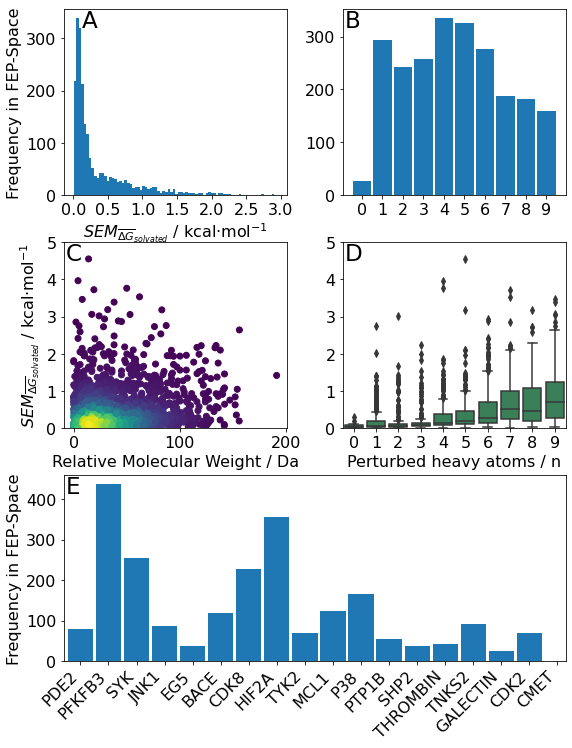

In [8]:
fig = plt.figure(figsize=(9, 12))

rows = 3
columns = 2

grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)

######################################################################

ax1 = plt.subplot(grid[2,:])
ax1.hist(tgt_data, rwidth=0.9, align='left', bins=len(tgt_data.unique())-1)
ax1.set_ylabel("Frequency in FEP-Space")
for label in ax1.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')
ax1.set_xlim(-0.6,)

######################################################################

ax2 = plt.subplot(grid[0,0])
ax2.hist(sem_data, bins=80) # this n bins makes the n_ha_plot y axis have the same scale so that we can hide the ticks.
ax2.set_xlabel("$SEM_{\overline{\Delta{G}}_{solvated}}$ / kcal$\cdot$mol$^{-1}$")
ax2.xaxis.set_major_locator(plt.MaxNLocator(8))
ax2.set_ylabel("Frequency in FEP-Space")

######################################################################

ax3 = plt.subplot(grid[0,1])
ax3.hist(n_ha_data, rwidth=0.9, align='left', bins=len(set(n_ha_data)))

#ax3.xaxis.set_major_locator(plt.MaxNLocator(9))

mids = [rect.get_x() + rect.get_width() / 2 for rect in ax3.patches]
ax3.set_xticks(mids)
ax3.set_xticklabels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#ax3.set_yticks([])
# ax3.set_ylabel("Frequency in FEP-Space")

######################################################################

# Calculate the point density
xy = np.vstack([mol_weight_data,sem_data_2])
z = gaussian_kde(xy)(xy)

ax4 = plt.subplot(grid[1,0])
ax4.scatter(mol_weight_data, sem_data_2, c=z)
ax4.set_xlabel("Relative Molecular Weight / Da")
ax4.set_ylabel("$SEM_{\overline{\Delta{G}}_{solvated}}$ / kcal$\cdot$mol$^{-1}$")
ax4.set_ylim(0, 5)

######################################################################

binned_sem_data = []
for i in range(10):
    bin_sems = []
    for sem, n_ha in zip(sem_data_2, n_ha_data):
        if n_ha == i:
            bin_sems.append(sem)
    binned_sem_data.append(bin_sems)
    
ax5 = plt.subplot(grid[1,1])
ax5.set_xlabel("Perturbed heavy atoms / n")

sns.boxplot(x=n_ha_data, y=sem_data_2, ax=ax5, color="seagreen")
ax5.set_ylim(0, 5)

######################################################################

indexing = ["A", "B", "C", "D", "E", "F", "G", "H"]
for i, ax in enumerate([ax2, ax3, ax4, ax5, ax1]):
    if i != 4:
        if i == 0:
            ax.annotate(indexing[i], xy=(0.08, 0.9), xycoords="axes fraction", size="x-large")
        else:
            ax.annotate(indexing[i], xy=(0.01, 0.9), xycoords="axes fraction", size="x-large")
    else:
        ax.annotate(indexing[i], xy=(0.005, 0.9), xycoords="axes fraction", size="x-large")
    
plt.show()

## Analyse A->B vs B->A SEMs in FEP-Space

In [21]:
mirror_df = fepspace_results
mirror_df["AB"] = fepspace_results["ligand1_smiles"] +"~"+ fepspace_results["ligand2_smiles"]
mirror_df["BA"] = fepspace_results["ligand2_smiles"] +"~"+ fepspace_results["ligand1_smiles"]

In [41]:
sem_values_ab = []
sem_values_ba = []


for idx, row in mirror_df.iterrows():
    ba_string = row["BA"]
    match = mirror_df[mirror_df["AB"] == ba_string].head(1)

    if len(match) == 1:
        ref_sem = row["fepspace_sem"]
        source_sem = match["fepspace_sem"].values[0]
        
        # append to arrays and try to distinguish between the larger and the smaller ligand.
        num_atoms_lig1 = len(row["ligand1_smiles"])
        num_atoms_lig2 = len(row["ligand2_smiles"])
        
        if num_atoms_lig1 > num_atoms_lig2:
            sem_values_ab.append(ref_sem)
            sem_values_ba.append(source_sem)
        else:
            sem_values_ab.append(source_sem)
            sem_values_ba.append(ref_sem)            
        


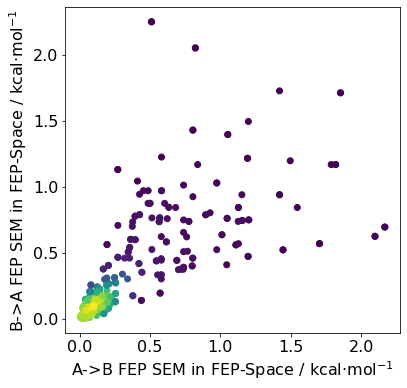

In [51]:
f, ax = plt.subplots(figsize=(6,6))


xy = np.vstack([sem_values_ab, sem_values_ba])
z = gaussian_kde(xy)(xy)
plt.scatter(sem_values_ab, sem_values_ba, c=z)

plt.xlabel("A->B FEP SEM in FEP-Space / kcal$\cdot$mol$^{-1}$")
plt.ylabel("B->A FEP SEM in FEP-Space / kcal$\cdot$mol$^{-1}$")
plt.show()

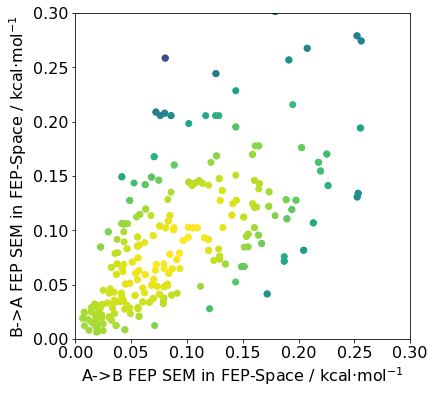

In [52]:
f, ax = plt.subplots(figsize=(6,6))


xy = np.vstack([sem_values_ab, sem_values_ba])
z = gaussian_kde(xy)(xy)
plt.scatter(sem_values_ab, sem_values_ba, c=z)

plt.xlabel("A->B FEP SEM in FEP-Space / kcal$\cdot$mol$^{-1}$")
plt.ylabel("B->A FEP SEM in FEP-Space / kcal$\cdot$mol$^{-1}$")
plt.xlim(0, 0.3)
plt.ylim(0, 0.3)
plt.show()

